# Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the summary() method.

In [1]:
from keras.applications import vgg16
from keras.models import Model


vgg = vgg16.VGG16(include_top=True, weights='imagenet')
vgg.summary()


553476096/553467096 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

Notice that VGG16 contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. 

VGG16 was made to solve ImageNet, and achieves a 8.8% top-5 error rate, which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way: **by using the keras Model class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called new_classification_layer.**

>Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.


In [2]:

from keras.layers import Dense
# make a reference to VGG's input layer
inp = vgg.input

# make a new dense layer
dense = Dense(4096, activation='relu')
out = dense(vgg.layers[-3].output)

# make a new softmax layer with num_classes (cat,dog) neurons
new_classification_layer = Dense(1, activation='sigmoid')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(out)

# create a new network between inp and out
model_new = Model(inp, out)

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last two layer2 are trainable/not frozen
for l, layer in enumerate(model_new.layers[-2:]):
    layer.trainable = True

model_new.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

IMG_DIM = (224, 224)

train_files = glob.glob('./data/train/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]
train_labels = np.array(np.unique(train_labels, return_inverse=True)[1]).reshape(-1,1)

validation_files = glob.glob('./data/valid/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[3].split('.')[0].strip() for fn in validation_files]
validation_labels = np.array(np.unique(validation_labels, return_inverse=True)[1]).reshape(-1,1)

# normalization
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255


In [8]:
history = model_new.fit(x=train_imgs_scaled, y=train_labels,
                    validation_data=(validation_imgs_scaled, validation_labels),
                    batch_size=16,
                    epochs=20,
                    verbose=1)

Epoch 1/20
17/17 [==============================] - 96s 5s/step - loss: 9.5809 - accuracy: 0.6070 - val_loss: 0.6232 - val_accuracy: 0.6183
Epoch 2/20
17/17 [==============================] - 100s 6s/step - loss: 0.4206 - accuracy: 0.8026 - val_loss: 1.1597 - val_accuracy: 0.4427
Epoch 3/20
17/17 [==============================] - 107s 6s/step - loss: 0.6451 - accuracy: 0.7615 - val_loss: 0.5366 - val_accuracy: 0.7176
Epoch 4/20
17/17 [==============================] - 106s 6s/step - loss: 0.5678 - accuracy: 0.7276 - val_loss: 0.4290 - val_accuracy: 0.8015
Epoch 5/20
17/17 [==============================] - 115s 7s/step - loss: 0.5792 - accuracy: 0.7203 - val_loss: 0.9470 - val_accuracy: 0.5344
Epoch 6/20
17/17 [==============================] - 127s 8s/step - loss: 0.2830 - accuracy: 0.8652 - val_loss: 0.3202 - val_accuracy: 0.8931
Epoch 7/20
17/17 [==============================] - 152s 9s/step - loss: 0.3047 - accuracy: 0.8563 - val_loss: 0.3482 - val_accuracy: 0.8473
Epoch 8/20
17/

In [9]:
loss, accuracy = model_new.evaluate(validation_imgs_scaled, validation_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 4.251014709472656
Test accuracy: 0.4122137427330017


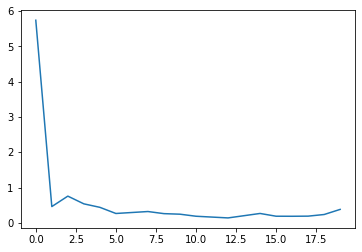

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [29]:
# load the image
imgs = [img_to_array(load_img('./data/valid/cat.5450.jpg', target_size=IMG_DIM))]
imgs.append(img_to_array(load_img('./data/valid/dog.12455.jpg', target_size=IMG_DIM)))
imgs = np.asarray(imgs)

model_new.predict(imgs)


array([[1.607944e-06],
       [1.000000e+00]], dtype=float32)

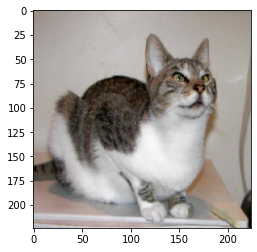

In [37]:

plt.imshow(load_img('./data/valid/cat.5450.jpg', target_size=IMG_DIM))

# What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification.

## Create the adversarial image

### Implementing fast gradient sign method

The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [54]:
import keras 
import tensorflow as tf

loss_object = keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model_new(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

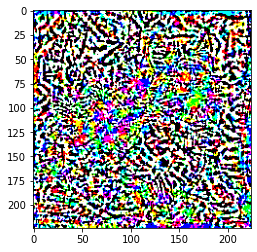

In [58]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

img=np.asarray(load_img('./data/valid/cat.5450.jpg'))
img= preprocess(img)

# Get the input label of the image.
perturbations = create_adversarial_pattern(img, np.array([[0]]))
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [62]:
def display_images(image, description):
  label = model_new.predict(image)
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{}'.format(label))
  plt.show()


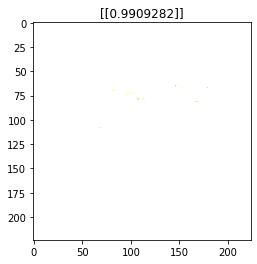

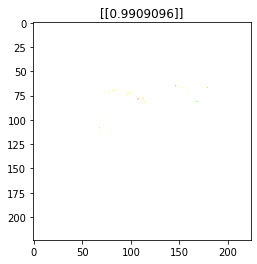

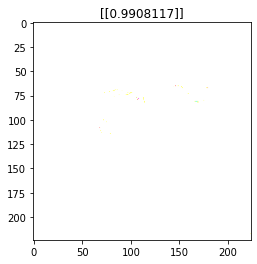

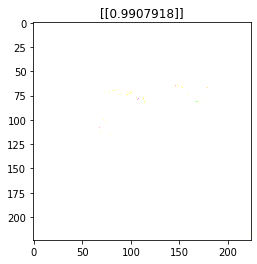

In [63]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])
